In [ ]:
# ## install finrl library
# !pip install wrds
# !pip install quantstats
# !pip install torch_geometric
# !pip install swig
# !pip install -q condacolab
# !pip install shimmy
# import condacolab
# condacolab.install()
# !apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
# !pip install git+https://github.com/flpymonkey/FinRL-Fork.git

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import TEST_TICKER

# from finrl.agents.portfolio_optimization.architectures import EIIE

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

# import sys
# sys.path.append("../FinRL-Library")

import itertools

In [7]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

In [8]:
# TODO, remove DOW from training as it is missing some values in 2019
print(TEST_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA']


In [9]:
TRAIN_START_DATE = '2009-04-01'
TRAIN_END_DATE = '2020-12-31'
TEST_START_DATE = '2021-01-01'
TEST_END_DATE = '2024-01-01'

# TRAIN_START_DATE = '2010-01-01'
# TRAIN_END_DATE = '2021-10-01'
# TEST_START_DATE = '2021-10-01'
# TEST_END_DATE = '2023-03-01'
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.config_tickers import TEST_TICKER


# No time window needed for PPO
# TIME_WINDOW = 25
COMMISSION_FEE_PERCENT = 0.001
INITIAL_CASH = 1000000

# TODO try different date ranges
# TRAIN_START_DATE = '2009-01-01'
# TRAIN_END_DATE = '2018-10-01'
# TEST_START_DATE = '2018-10-01'
# TEST_END_DATE = '2021-03-01'

raw_df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = TEST_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (14852, 8)


In [10]:
print(raw_df)

             date        open        high         low       close     volume  \
0      2009-04-01    3.717500    3.892857    3.710357    3.274470  589372000   
1      2009-04-01   48.779999   48.930000   47.099998   34.259605   10850100   
2      2009-04-01   13.340000   14.640000   13.080000   11.493887   27701800   
3      2009-04-01   34.520000   35.599998   34.209999   26.850748    9288800   
4      2009-04-02    3.933571    4.098214    3.920714    3.395578  812366800   
...           ...         ...         ...         ...         ...        ...   
14847  2023-12-28  261.529999  262.100006  257.679993  260.350006    5096400   
14848  2023-12-29  193.899994  194.399994  191.729996  191.591400   42628800   
14849  2023-12-29  287.859985  288.489990  286.390015  281.808197    1766600   
14850  2023-12-29  187.750000  188.300003  186.529999  185.607086    1913800   
14851  2023-12-29  260.670013  262.220001  259.559998  260.660004    3681900   

        tic  day  
0      AAPL    2  
1

In [11]:
# INDICATORS = ['macd',
#             'rsi_30',
#             'cci_30',
#             'dx_30']

In [12]:
# from finrl.meta.preprocessor.preprocessors import FeatureEngineer
# fe = FeatureEngineer(use_technical_indicator=True,
#                      tech_indicator_list = INDICATORS,
#                      use_turbulence=True,
#                      user_defined_feature = False)

# processed = fe.preprocess_data(df)
# processed = processed.copy()
# processed = processed.fillna(0)
# processed = processed.replace(np.inf,0)

# # here you can see the engineered features are added to each stock day
# print(processed)


In [13]:
from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(raw_df)

In [14]:
portfolio_norm_df.groupby("tic").count()

,date,open,high,low,close,volume,day
tic,,,,,,,
AAPL,3713,3713,3713,3713,3713,3713,3713
AMGN,3713,3713,3713,3713,3713,3713,3713
AXP,3713,3713,3713,3713,3713,3713,3713
BA,3713,3713,3713,3713,3713,3713,3713


In [15]:
stock_dimension = len(portfolio_norm_df.tic.unique())
print(f"Stock Dimension: {stock_dimension}")

Stock Dimension: 4


In [16]:
df_train = portfolio_norm_df[(portfolio_norm_df["date"] >= TRAIN_START_DATE) & (portfolio_norm_df["date"] <= TRAIN_END_DATE)]
df_2021 = portfolio_norm_df[(portfolio_norm_df["date"] >= TEST_START_DATE) & (portfolio_norm_df["date"] <= "2021-12-31")]
df_2022 = portfolio_norm_df[(portfolio_norm_df["date"] >= "2022-01-01") & (portfolio_norm_df["date"] <= "2022-12-31")]
df_2023 = portfolio_norm_df[(portfolio_norm_df["date"] >= "2023-01-01") & (portfolio_norm_df["date"] < TEST_END_DATE)]

# TODO use the start and end date here

df_train.groupby("tic").count()

,date,open,high,low,close,volume,day
tic,,,,,,,
AAPL,2960,2960,2960,2960,2960,2960,2960
AMGN,2960,2960,2960,2960,2960,2960,2960
AXP,2960,2960,2960,2960,2960,2960,2960
BA,2960,2960,2960,2960,2960,2960,2960


In [17]:
  # TODO here they use the covariance matrix for the state, look at the tutorial for:
 # FinRL_PortfolioAllocation_NeurIPS_2020

# environment = PortfolioOptimizationEnv(
#         df_train,
#         initial_amount=INITIAL_CASH,
#         comission_fee_pct=COMMISSION_FEE_PERCENT,
#         time_window=TIME_WINDOW,
#         features=["close", "high", "low"],
#         normalize_df=None
#     )

In [18]:
# import torch
# device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# # set PolicyGradient parameters
# model_kwargs = {
#     "lr": 0.01,
#     "policy": EIIE,
# }

# # here, we can set EIIE's parameters
# policy_kwargs = {
#     "k_size": 3,
#     "time_window": TIME_WINDOW,
# }

# model = DRLAgent(environment).get_model("pg", device, model_kwargs, policy_kwargs)

In [19]:

# Once optimal policy is learned it shouldnt be stochastic, giventhe state

# model = DRLAgent.train_model(model, episodes=3)

In [20]:
# torch.save(model.train_policy.state_dict(), "policy_EIIE.pt")

In [21]:
# # Test it

# environment_2021 = PortfolioOptimizationEnv(
#     df_2021,
#     initial_amount=INITIAL_CASH,
#     comission_fee_pct=COMMISSION_FEE_PERCENT,
#     time_window=TIME_WINDOW,
#     features=["close", "high", "low"],
#     normalize_df=None
# )

# environment_2022 = PortfolioOptimizationEnv(
#     df_2022,
#     initial_amount=INITIAL_CASH,
#     comission_fee_pct=COMMISSION_FEE_PERCENT,
#     time_window=TIME_WINDOW,
#     features=["close", "high", "low"],
#     normalize_df=None
# )

# environment_2023 = PortfolioOptimizationEnv(
#     df_2023,
#     initial_amount=INITIAL_CASH,
#     comission_fee_pct=COMMISSION_FEE_PERCENT,
#     time_window=TIME_WINDOW,
#     features=["close", "high", "low"],
#     normalize_df=None
# )

In [22]:
# EIIE_results = {
#     "date": environment._date_memory,
#     "training": environment._asset_memory["final"],
#     "2021": {},
#     "2022": {},
#     "2023": {}
# }

# # instantiate an architecture with the same arguments used in training
# # and load with load_state_dict.
# policy = EIIE(time_window=TIME_WINDOW, device=device)
# policy.load_state_dict(torch.load("policy_EIIE.pt"))

# # 2021
# DRLAgent.DRL_validation(model, environment_2021, policy=policy)
# EIIE_results["2021"]["value"] = environment_2021._asset_memory["final"]
# EIIE_results["2021"]["date"] = environment_2021._date_memory

# # 2022
# DRLAgent.DRL_validation(model, environment_2022, policy=policy)
# EIIE_results["2022"]["value"] = environment_2022._asset_memory["final"]
# EIIE_results["2022"]["date"] = environment_2022._date_memory

# # 2023
# DRLAgent.DRL_validation(model, environment_2023, policy=policy)
# EIIE_results["2023"]["value"] = environment_2023._asset_memory["final"]
# EIIE_results["2023"]["date"] = environment_2023._date_memory

In [23]:
# UBAH_results = {
#     "train": {},
#     "2021": {},
#     "2022": {},
#     "2023": {},
# }

# PORTFOLIO_SIZE = len(DOW_30_TICKER)

# # train period
# terminated = False
# environment.reset()
# while not terminated:
#     action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
#     _, _, terminated, _ = environment.step(action)
# UBAH_results["train"]["value"] = environment._asset_memory["final"]
# UBAH_results["train"]["date"] = environment._date_memory

# # 2021
# terminated = False
# environment_2021.reset()
# while not terminated:
#     action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
#     _, _, terminated, _ = environment_2021.step(action)
# UBAH_results["2021"]["value"] = environment_2021._asset_memory["final"]
# UBAH_results["2021"]["date"] = environment_2021._date_memory

# # 2022
# terminated = False
# environment_2022.reset()
# while not terminated:
#     action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
#     _, _, terminated, _ = environment_2022.step(action)
# UBAH_results["2022"]["value"] = environment_2022._asset_memory["final"]
# UBAH_results["2022"]["date"] = environment_2022._date_memory

# # 2023
# terminated = False
# environment_2023.reset()
# while not terminated:
#     action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
#     _, _, terminated, _ = environment_2023.step(action)
# UBAH_results["2023"]["value"] = environment_2023._asset_memory["final"]
# UBAH_results["2023"]["date"] = environment_2023._date_memory

# print(UBAH_results)

In [24]:
# import matplotlib.pyplot as plt
# %matplotlib inline 

# plt.plot(UBAH_results["train"]["date"], UBAH_results["train"]["value"], label="Buy and Hold")
# plt.plot(EIIE_results["date"], EIIE_results["training"], label="EIIE")

# plt.xlabel("Days")
# plt.ylabel("Portfolio Value")
# plt.title("Performance in training period")
# plt.legend()

# plt.show()

In [25]:
# plt.plot(UBAH_results["2021"]["date"], UBAH_results["2021"]["value"], label="Buy and Hold")
# plt.plot(EIIE_results["2021"]["date"], EIIE_results["2021"]["value"], label="EIIE")

# plt.xlabel("Days")
# plt.ylabel("Portfolio Value")
# plt.title("Performance in 2021")
# plt.legend()

# plt.show()

In [26]:
# plt.plot(UBAH_results["2022"]["date"], UBAH_results["2022"]["value"], label="Buy and Hold")
# plt.plot(EIIE_results["2022"]["date"], EIIE_results["2022"]["value"], label="EIIE")

# plt.xlabel("Days")
# plt.ylabel("Portfolio Value")
# plt.title("Performance in 2022")
# plt.legend()

# plt.show()

In [27]:
# plt.plot(UBAH_results["2023"]["date"], UBAH_results["2023"]["value"], label="Buy and Hold")
# plt.plot(EIIE_results["2023"]["date"], EIIE_results["2023"]["value"], label="EIIE")

# plt.xlabel("Days")
# plt.ylabel("Portfolio Value")
# plt.title("Performance in 2023")
# plt.legend()

# plt.show()

# TODO can I used ANOVA, or Analysis of Variance,

Compare with ANova,
Returns 
Drawdown period
And sharpe ratio

In [28]:
import torch
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [29]:
from finrl.meta.env_portfolio_optimization.env_portfolio_opt_stable import PortfolioOptStableEnv

from finrl.agents.portfolio_optimization.models_stable import DRLStableAgent



from stable_baselines3.common.logger import configure
# Try also training a PPO agent on this same environment


environment = PortfolioOptStableEnv(
        df_train,
        initial_amount=INITIAL_CASH,
        comission_fee_pct=COMMISSION_FEE_PERCENT,
        # time_window=TIME_WINDOW,
        features=["close", "high", "low"],
        normalize_df=None,
        reward_scaling=1e-4,
    )


# TODO use reward scaling reward_scaling


# TODO figuring out issues with timesteps: https://stackoverflow.com/questions/56700948/understanding-the-total-timesteps-parameter-in-stable-baselines-models

print (TENSORBOARD_LOG_DIR)
agent_ppo = DRLStableAgent(env = environment)
PPO_PARAMS = {
    "n_steps": 50,
    # "ent_coef": 0.2,
    "learning_rate": 0.00025, # TODO tried raising the lr which caused vanishing problem
    # "clip_range": 0.2
}

# POLICY_PARAMS = {
#     "log_std_init": 4 # TODO disable this Try increasing the variance of the policy distributions
# }
# Note, setting this to a negative value brings the training period closer to the CRP


# Lower clip_range makes the stocks flatter, very conservative policy

# TODO try playing around with the number of epochs? n_epochs
# TODO try playing around more with the entropy term, make sure agent does enough exploration during training
# TODO try playing around more with the clip papram here


model_ppo = agent_ppo.get_model("ppo", device, model_kwargs=PPO_PARAMS, policy_kwargs=None)

import datetime
# Current timestamp 
now = datetime.datetime.now() 
timestamp = now.strftime("%Y%m%d_%H%M%S")

# set up logger
tmp_path = RESULTS_DIR + '/ppo' + timestamp
new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
# Set new logger
model_ppo.set_logger(new_logger_ppo)

tensorboard_log
Logging to results/ppo20241109_174524


In [30]:
# Once optimal policy is learned it shouldnt be stochastic, giventhe state

# TODO see graphs below, need to have the correct number of timestemps and add epochs
model_ppo = DRLStableAgent.train_model(model_ppo, env=environment, tb_log_name="ppo_log", episodes=10)

from finrl.config import TRAINED_MODEL_DIR

model_ppo.save(TRAINED_MODEL_DIR + "/agent_opt_ppo")

Max number of time steps in an episode:  2960
-----------------------------
| time/              |      |
|    fps             | 92   |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 50   |
| train/             |      |
|    reward          | None |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 91           |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 100          |
| train/                  |              |
|    approx_kl            | 0.0005974078 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -7.09        |
|    explained_variance   | 0.056        |
|    learning_rate        | 0.00025      |
|    loss                 | -0.0117      |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00579   

=================================

Initial portfolio value:1000000

Final portfolio value: 2454081.5

Final accumulative portfolio value: 2.4540815

Maximum DrawDown: -0.3795302279903353

Sharpe ratio: 0.49982084141477895

Total commission cost: 2560970.19842834

=================================

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.96e+03    |
|    ep_rew_mean          | 9e-05       |
| time/                   |             |
|    fps                  | 90          |
|    iterations           | 60          |
|    time_elapsed         | 33          |
|    total_timesteps      | 3000        |
| train/                  |             |
|    approx_kl            | 0.002491244 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.07       |
|    explained_variance   | -0.713      |
|    learning_rate        | 0.00025     |
|    loss                 | -0.0118     |
|    n_updates            | 590         |
|    policy_gradient_loss | -0.00117    |
|    reward               | None        |
|    std                  | 0.996       |
|    value_loss           | 9.42e-05    |
-----------------------------------------
----------------------------------

=================================

Initial portfolio value:1000000

Final portfolio value: 2674333.0

Final accumulative portfolio value: 2.674333

Maximum DrawDown: -0.48245919225752676

Sharpe ratio: 0.5320509603917937

Total commission cost: 2677265.474458177

=================================

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.96e+03    |
|    ep_rew_mean          | 9.4e-05     |
| time/                   |             |
|    fps                  | 66          |
|    iterations           | 119         |
|    time_elapsed         | 89          |
|    total_timesteps      | 5950        |
| train/                  |             |
|    approx_kl            | 0.008075591 |
|    clip_fraction        | 0.026       |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.06       |
|    explained_variance   | -6.07       |
|    learning_rate        | 0.00025     |
|    loss                 | -0.0229     |
|    n_updates            | 1180        |
|    policy_gradient_loss | -0.0132     |
|    reward               | None        |
|    std                  | 0.993       |
|    value_loss           | 3.54e-05    |
-----------------------------------------
----------------------------------

=================================

Initial portfolio value:1000000

Final portfolio value: 2242317.75

Final accumulative portfolio value: 2.24231775

Maximum DrawDown: -0.3935841763167003

Sharpe ratio: 0.4446736183386019

Total commission cost: 2038208.9523447547

=================================

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 2.96e+03     |
|    ep_rew_mean          | 8.97e-05     |
| time/                   |              |
|    fps                  | 50           |
|    iterations           | 178          |
|    time_elapsed         | 174          |
|    total_timesteps      | 8900         |
| train/                  |              |
|    approx_kl            | 0.0021539426 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -7.17        |
|    explained_variance   | -5.07        |
|    learning_rate        | 0.00025      |
|    loss                 | -0.00137     |
|    n_updates            | 1770         |
|    policy_gradient_loss | 0.00163      |
|    reward               | None         |
|    std                  | 1.02         |
|    value_loss           | 2.57e-05     |
------------------------------------------
-----------

=================================

Initial portfolio value:1000000

Final portfolio value: 1987815.375

Final accumulative portfolio value: 1.987815375

Maximum DrawDown: -0.44120264341692284

Sharpe ratio: 0.402609859230536

Total commission cost: 2336420.003729986

=================================

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 2.96e+03   |
|    ep_rew_mean          | 8.45e-05   |
| time/                   |            |
|    fps                  | 45         |
|    iterations           | 237        |
|    time_elapsed         | 258        |
|    total_timesteps      | 11850      |
| train/                  |            |
|    approx_kl            | 0.00985707 |
|    clip_fraction        | 0.03       |
|    clip_range           | 0.2        |
|    entropy_loss         | -7.09      |
|    explained_variance   | -14.6      |
|    learning_rate        | 0.00025    |
|    loss                 | -0.04      |
|    n_updates            | 2360       |
|    policy_gradient_loss | -0.0173    |
|    reward               | None       |
|    std                  | 0.999      |
|    value_loss           | 2.89e-05   |
----------------------------------------
------------------------------------------
| rollout/    

=================================

Initial portfolio value:1000000

Final portfolio value: 1703047.25

Final accumulative portfolio value: 1.70304725

Maximum DrawDown: -0.3452936791767398

Sharpe ratio: 0.352489736319457

Total commission cost: 1846057.674862781

=================================

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.96e+03    |
|    ep_rew_mean          | 7.84e-05    |
| time/                   |             |
|    fps                  | 43          |
|    iterations           | 296         |
|    time_elapsed         | 342         |
|    total_timesteps      | 14800       |
| train/                  |             |
|    approx_kl            | 0.012598366 |
|    clip_fraction        | 0.058       |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.1        |
|    explained_variance   | -17.1       |
|    learning_rate        | 0.00025     |
|    loss                 | -0.0147     |
|    n_updates            | 2950        |
|    policy_gradient_loss | -0.00962    |
|    reward               | None        |
|    std                  | 1           |
|    value_loss           | 1.45e-05    |
-----------------------------------------
----------------------------------

=================================

Initial portfolio value:1000000

Final portfolio value: 2767691.25

Final accumulative portfolio value: 2.76769125

Maximum DrawDown: -0.32758382982231704

Sharpe ratio: 0.6042537031488363

Total commission cost: 1926802.2472020753

=================================

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 2.96e+03     |
|    ep_rew_mean          | 8.23e-05     |
| time/                   |              |
|    fps                  | 41           |
|    iterations           | 356          |
|    time_elapsed         | 427          |
|    total_timesteps      | 17800        |
| train/                  |              |
|    approx_kl            | 0.0041552987 |
|    clip_fraction        | 0.006        |
|    clip_range           | 0.2          |
|    entropy_loss         | -7.08        |
|    explained_variance   | -0.663       |
|    learning_rate        | 0.00025      |
|    loss                 | -0.0157      |
|    n_updates            | 3550         |
|    policy_gradient_loss | -0.0014      |
|    reward               | None         |
|    std                  | 0.998        |
|    value_loss           | 7.41e-06     |
------------------------------------------
-----------

=================================

Initial portfolio value:1000000

Final portfolio value: 3129328.25

Final accumulative portfolio value: 3.12932825

Maximum DrawDown: -0.3935758412507524

Sharpe ratio: 0.6556800209459057

Total commission cost: 1611551.9167319164

=================================

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.96e+03    |
|    ep_rew_mean          | 8.69e-05    |
| time/                   |             |
|    fps                  | 40          |
|    iterations           | 415         |
|    time_elapsed         | 509         |
|    total_timesteps      | 20750       |
| train/                  |             |
|    approx_kl            | 0.009049443 |
|    clip_fraction        | 0.038       |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.04       |
|    explained_variance   | -7.4        |
|    learning_rate        | 0.00025     |
|    loss                 | -0.00694    |
|    n_updates            | 4140        |
|    policy_gradient_loss | -0.00307    |
|    reward               | None        |
|    std                  | 0.989       |
|    value_loss           | 6.22e-06    |
-----------------------------------------
----------------------------------

=================================

Initial portfolio value:1000000

Final portfolio value: 3831526.5

Final accumulative portfolio value: 3.8315265

Maximum DrawDown: -0.4357092915604396

Sharpe ratio: 0.6893227259932146

Total commission cost: 1286831.0864224155

=================================

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.96e+03    |
|    ep_rew_mean          | 9.28e-05    |
| time/                   |             |
|    fps                  | 39          |
|    iterations           | 474         |
|    time_elapsed         | 594         |
|    total_timesteps      | 23700       |
| train/                  |             |
|    approx_kl            | 0.047225088 |
|    clip_fraction        | 0.22        |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.97       |
|    explained_variance   | -44.8       |
|    learning_rate        | 0.00025     |
|    loss                 | -0.0382     |
|    n_updates            | 4730        |
|    policy_gradient_loss | -0.029      |
|    reward               | None        |
|    std                  | 0.978       |
|    value_loss           | 0.000216    |
-----------------------------------------
----------------------------------

=================================

Initial portfolio value:1000000

Final portfolio value: 4479640.0

Final accumulative portfolio value: 4.47964

Maximum DrawDown: -0.4272762782761783

Sharpe ratio: 0.7628101681036518

Total commission cost: 1043202.4279561456

=================================

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.96e+03    |
|    ep_rew_mean          | 9.91e-05    |
| time/                   |             |
|    fps                  | 39          |
|    iterations           | 533         |
|    time_elapsed         | 678         |
|    total_timesteps      | 26650       |
| train/                  |             |
|    approx_kl            | 0.013410146 |
|    clip_fraction        | 0.076       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.97       |
|    explained_variance   | -1.26       |
|    learning_rate        | 0.00025     |
|    loss                 | -0.0186     |
|    n_updates            | 5320        |
|    policy_gradient_loss | -0.0104     |
|    reward               | None        |
|    std                  | 0.977       |
|    value_loss           | 1.02e-05    |
-----------------------------------------
----------------------------------

=================================

Initial portfolio value:1000000

Final portfolio value: 5218886.0

Final accumulative portfolio value: 5.218886

Maximum DrawDown: -0.40479491563530645

Sharpe ratio: 0.8359500385667251

Total commission cost: 1104345.3183014952

=================================

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.96e+03    |
|    ep_rew_mean          | 0.000106    |
| time/                   |             |
|    fps                  | 39          |
|    iterations           | 592         |
|    time_elapsed         | 758         |
|    total_timesteps      | 29600       |
| train/                  |             |
|    approx_kl            | 0.010381251 |
|    clip_fraction        | 0.048       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.92       |
|    explained_variance   | -4.6        |
|    learning_rate        | 0.00025     |
|    loss                 | -0.0404     |
|    n_updates            | 5910        |
|    policy_gradient_loss | -0.0203     |
|    reward               | None        |
|    std                  | 0.966       |
|    value_loss           | 9.89e-06    |
-----------------------------------------


In [31]:
print(len(df_2021.index.unique()) - 1)
print(df_2021)

1007
             date      open      high       low     close    volume   tic  \
11840  2021-01-04  0.674275  0.669322  0.643452  0.641887  0.076184  AAPL   
11841  2021-01-04  0.786351  0.779486  0.773249  0.714092  0.061718  AMGN   
11842  2021-01-04  0.614177  0.610373  0.592425  0.586691  0.038435   AXP   
11843  2021-01-04  0.470841  0.471290  0.460006  0.471113  0.205649    BA   
11844  2021-01-05  0.650894  0.659954  0.651929  0.649823  0.051922  AAPL   
...           ...       ...       ...       ...       ...       ...   ...   
12843  2021-12-30  0.455147  0.461873  0.460256  0.471090  0.067943    BA   
12844  2021-12-31  0.899354  0.897856  0.899797  0.886195  0.034058  AAPL   
12845  2021-12-31  0.769382  0.767654  0.777155  0.730695  0.033343  AMGN   
12846  2021-12-31  0.830886  0.827712  0.827672  0.822615  0.019301   AXP   
12847  2021-12-31  0.453353  0.456694  0.454417  0.467860  0.078023    BA   

        day  
11840  0.00  
11841  0.00  
11842  0.00  
11843  0.00  


In [32]:
PPO_results = {
    "date": environment._terminal_date_memory,
    "training": environment._terminal_asset_memory["final"],
    "2021": {},
    "2022": {},
    "2023": {}
}


environment_2021 = PortfolioOptStableEnv(
    df_2021,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    # time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)


environment_2022 = PortfolioOptStableEnv(
    df_2022,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    # time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)

environment_2023 = PortfolioOptStableEnv(
    df_2023,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    # time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)


print(model_ppo._num_timesteps_at_start)

# 2021
values, dates = DRLStableAgent.DRL_prediction(model_ppo, environment_2021, deterministic=False, verbose=True)
PPO_results["2021"]["value"] = environment_2021._terminal_asset_memory["final"]
PPO_results["2021"]["date"] = environment_2021._terminal_date_memory


# 2022
values, dates = DRLStableAgent.DRL_prediction(model_ppo, environment_2022)
PPO_results["2022"]["value"] = environment_2022._terminal_asset_memory["final"]
PPO_results["2022"]["date"] = environment_2022._terminal_date_memory

# # 2023
# DRLStableAgent.DRL_prediction(model_ppo, environment_2023)
# PPO_results["2023"]["value"] = environment_2023._asset_memory["final"]
# PPO_results["2023"]["date"] = environment_2023._date_memory

0
Step:  0
Observations: 
[[[[0.6418866 ]
   [0.7140924 ]
   [0.58669066]
   [0.4711132 ]]

  [[0.6693217 ]
   [0.7794856 ]
   [0.6103733 ]
   [0.47128987]]

  [[0.6434518 ]
   [0.773249  ]
   [0.59242547]
   [0.4600059 ]]]]
Actions: 
[[1. 0. 0. 1. 1.]]
Step:  1
Observations: 
[[[[0.6498227 ]
   [0.71755797]
   [0.58982193]
   [0.49181968]]

  [[0.65995395]
   [0.7715643 ]
   [0.5977449 ]
   [0.47835252]]

  [[0.6519289 ]
   [0.7755998 ]
   [0.59369296]
   [0.4647993 ]]]]
Actions: 
[[1. 0. 0. 1. 1.]]
Step:  2
Observations: 
[[[[0.6279487 ]
   [0.7348543 ]
   [0.6116413 ]
   [0.4904253 ]]

  [[0.65649736]
   [0.7871709 ]
   [0.6250564 ]
   [0.48341966]]

  [[0.6415228 ]
   [0.7778469 ]
   [0.6125025 ]
   [0.47556737]]]]
Actions: 
[[1. 0. 0. 1. 1.]]
Step:  3
Observations: 
[[[[0.64937645]
   [0.7372802 ]
   [0.6068033 ]
   [0.49432957]]

  [[0.6594029 ]
   [0.79337305]
   [0.6298672 ]
   [0.48563933]]

  [[0.6490355 ]
   [0.8002143 ]
   [0.59496045]
   [0.48111042]]]]
Actions: 
[[1.     

In [33]:
print(len(df_2021['date'].unique()) - 1)

print(len(PPO_results['date']))

251
2960


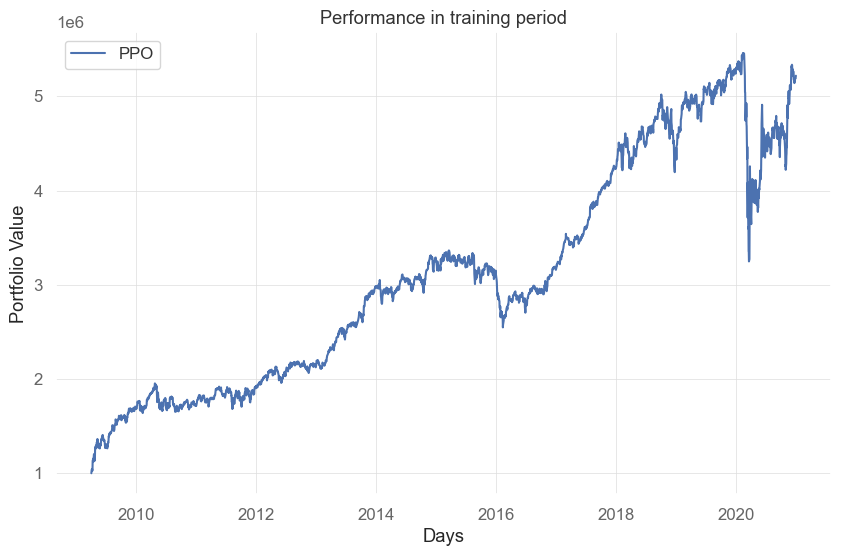

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(PPO_results["date"], PPO_results["training"], label="PPO")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period")
plt.legend()

plt.show()

In [35]:
UBAH_results = {
    "train": {},
    "2021": {},
    "2022": {},
    "2023": {},
}

PORTFOLIO_SIZE = len(TEST_TICKER)



# This is the CRP strategy NOT Buy and hold 
# train period
terminated = False
environment.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment.step(action)
UBAH_results["train"]["value"] = environment._terminal_asset_memory["final"]
UBAH_results["train"]["date"] = environment._terminal_date_memory

# 2021
terminated = False
environment_2021.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2021.step(action)
UBAH_results["2021"]["value"] = environment_2021._terminal_asset_memory["final"]
UBAH_results["2021"]["date"] = environment_2021._terminal_date_memory

# 2022
terminated = False
environment_2022.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2022.step(action)
UBAH_results["2022"]["value"] = environment_2022._terminal_asset_memory["final"]
UBAH_results["2022"]["date"] = environment_2022._terminal_date_memory

# # 2023
# terminated = False
# environment_2023.reset()
# while not terminated:
#     action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
#     _, _, terminated, _ = environment_2023.step(action)
# UBAH_results["2023"]["value"] = environment_2023._terminal_asset_memory["final"]
# UBAH_results["2023"]["date"] = environment_2023._terminal_date_memory

Initial portfolio value:1000000
Final portfolio value: 14594244.0
Final accumulative portfolio value: 14.594244
Maximum DrawDown: -0.4458334096155907
Sharpe ratio: 1.1214743420345885
Total commission cost: 157560.09726924438
Initial portfolio value:1000000
Final portfolio value: 1207516.75
Final accumulative portfolio value: 1.20751675
Maximum DrawDown: -0.0955046894717585
Sharpe ratio: 1.1380103934352854
Total commission cost: 2852.856926171691
Initial portfolio value:1000000
Final portfolio value: 937761.9375
Final accumulative portfolio value: 0.9377619375
Maximum DrawDown: -0.2500667619428778
Sharpe ratio: -0.1020283935935641
Total commission cost: 2497.1289942316944


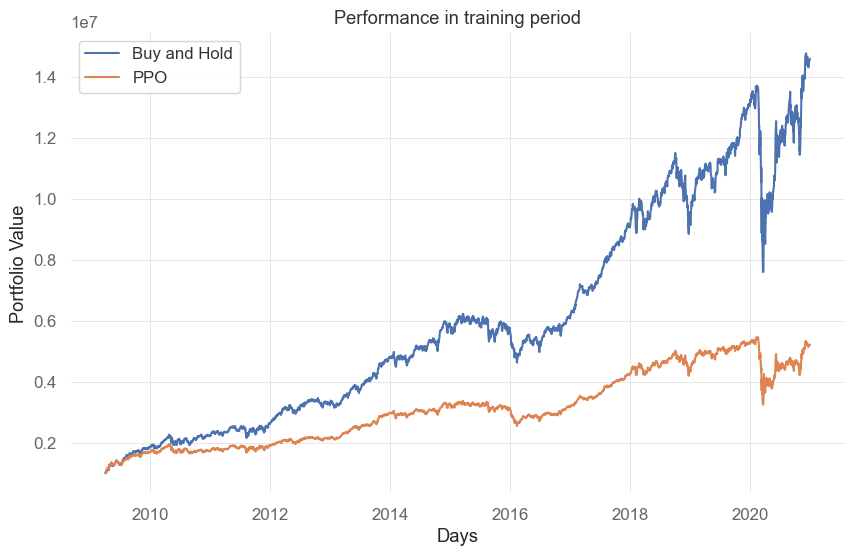

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(UBAH_results["train"]["date"], UBAH_results["train"]["value"], label="Buy and Hold")
plt.plot(PPO_results["date"], PPO_results["training"], label="PPO")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period")
plt.legend()

plt.show()

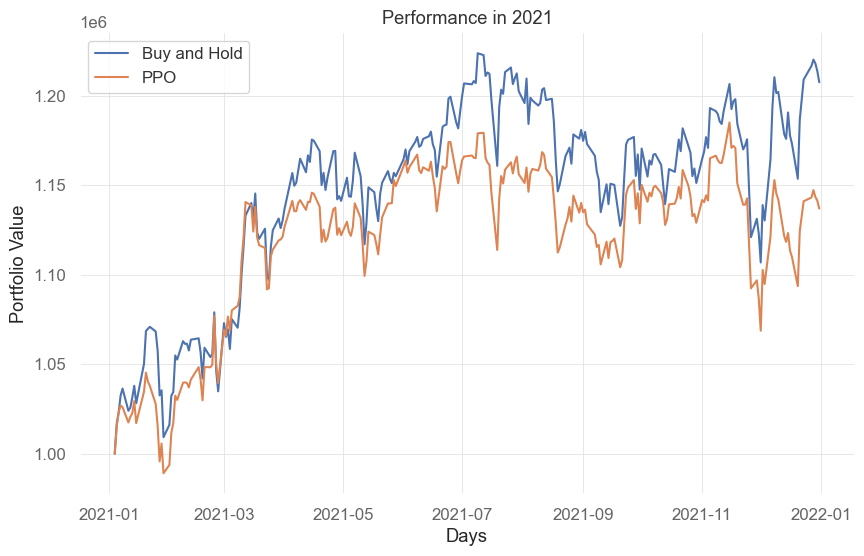

In [37]:
plt.plot(UBAH_results["2021"]["date"], UBAH_results["2021"]["value"], label="Buy and Hold")
plt.plot(PPO_results["2021"]["date"], PPO_results["2021"]["value"], label="PPO")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2021")
plt.legend()

plt.show()

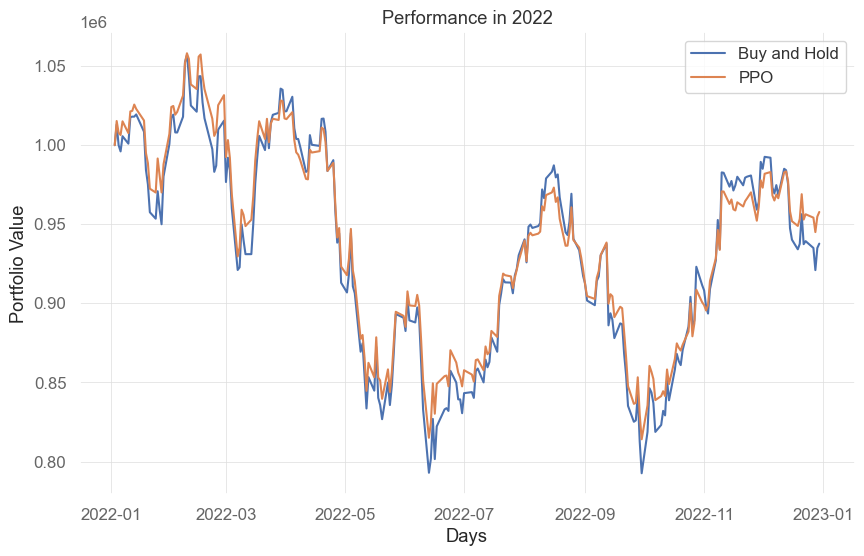

In [38]:
plt.plot(UBAH_results["2022"]["date"], UBAH_results["2022"]["value"], label="Buy and Hold")
plt.plot(PPO_results["2022"]["date"], PPO_results["2022"]["value"], label="PPO")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2022")
plt.legend()

plt.show()

In [39]:
# plt.plot(UBAH_results["2023"]["date"], UBAH_results["2023"]["value"], label="Buy and Hold")
# plt.plot(PPO_results["2023"]["date"], PPO_results["2023"]["value"], label="PPO")

# plt.xlabel("Days")
# plt.ylabel("Portfolio Value")
# plt.title("Performance in 2023")
# plt.legend()

# plt.show()

In [ ]:
# Use this to download from collab

# import shutil
# shutil.make_archive('train', 'zip', '../content')

# from google.colab import files
# files.download("train.zip")